In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import sleep
from tqdm import tqdm
import xlrd
from fuzzywuzzy import process
import Levenshtein

In [2]:
# Read in the csv file containing the training data
df = pd.read_csv('TrainingSet.csv', header=0)
df = df.drop('Unnamed: 0', axis=1) # drop the first column
df.head()

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.933105,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.996814,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection


In [3]:
# Need to get a list of unique countries
countries = pd.unique(df['Country Name'])
print('There are ' + str(len(countries)) + ' countries in this dataset.')

There are 214 countries in this dataset.


In [4]:
# There should be the same number of series names as series codes.

# Need to get a list of unique series codes
seriesCodes = pd.unique(df['Series Code'])

# Need to get a list of unique series names
seriesNames = pd.unique(df['Series Name'])

# Ensure that the number of codes and the number of names are the same -- every series name has a series code
assert len(seriesCodes) == len(seriesNames)

print('There are ' + str(len(seriesNames)) + ' series in this dataset.')

There are 1305 series in this dataset.


In [5]:
# Clean up the years
years = df.columns[:-3]
years = [x[:4] for x in years]

print('There are ' + str(len(years)) + ' years in this dataset.')

There are 36 years in this dataset.


In [6]:
# Reset the column names
new_columns = years.copy()
new_columns.extend(['Country Name', 'Series Code', 'Series Name'])
print(new_columns)
df.columns = new_columns

['1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', 'Country Name', 'Series Code', 'Series Name']


In [7]:
df.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,2001,2002,2003,2004,2005,2006,2007,Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.933105,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.996814,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection


In [8]:
# Change columns to rows and vice versa
melted_df = pd.melt(df, id_vars=['Series Code', 'Series Name', 'Country Name'], value_vars=years)

In [9]:
melted_df

,Series Code,Series Name,Country Name,variable,value
0,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...,Afghanistan,1972,NaN
1,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...,Afghanistan,1972,NaN
2,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...,Afghanistan,1972,NaN
3,allsi.gen_pop,(%) Generosity of All Social Insurance,Afghanistan,1972,NaN
4,allsp.gen_pop,(%) Generosity of All Social Protection,Afghanistan,1972,NaN
...,...,...,...,...,...
7034467,SG.VAW.BURN.ZS,Women who believe a husband is justified in be...,Zimbabwe,2007,NaN
7034468,SG.VAW.GOES.ZS,Women who believe a husband is justified in be...,Zimbabwe,2007,NaN
7034469,SG.VAW.NEGL.ZS,Women who believe a husband is justified in be...,Zimbabwe,2007,NaN
7034470,SG.VAW.REFU.ZS,Women who believe a husband is justified in be...,Zimbabwe,2007,NaN


In [10]:
# Let's check that our values match the original - zimbabwe 2007 for the final series should be 58.3 and it matches
df.loc[(df['Country Name'] == 'Zimbabwe') &
       (df['Series Code'] == 'SH.DYN.AIDS.FE.ZS') , '2007']

195401    58.3
Name: 2007, dtype: float64

In [11]:
# We have both a Series Name and Series Code as identifiers but only need one of them, so we drop the Series Code.
melted_df = melted_df.drop('Series Code', axis=1)
melted_df.columns = ['series', 'country', 'year', 'value']

In [12]:
melted_df.head()

,series,country,year,value
0,(%) Benefits held by 1st 20% population - All ...,Afghanistan,1972,NaN
1,(%) Benefits held by 1st 20% population - All ...,Afghanistan,1972,NaN
2,(%) Benefits held by 1st 20% population - All ...,Afghanistan,1972,NaN
3,(%) Generosity of All Social Insurance,Afghanistan,1972,NaN
4,(%) Generosity of All Social Protection,Afghanistan,1972,NaN


In [13]:
# Now that we have years as rows, we need to set the Series Names to the columns
# the unstack() fuction helps us do that
unstacked_df = melted_df.set_index(['country', 'year', 'series'])['value'].unstack().reset_index()

In [14]:
unstacked_df.head()

series,country,year,(%) Benefits held by 1st 20% population - All Social Insurance,(%) Benefits held by 1st 20% population - All Social Protection,(%) Benefits held by 1st 20% population - All Social Safety Nets,(%) Benefits held by 1st 20% population - Unemp benefits and ALMP,(%) Generosity of All Social Insurance,(%) Generosity of All Social Protection,(%) Generosity of All Social Safety Nets,(%) Generosity of Unemp benefits and ALMP,...,"Water pollution, wood industry (% of total BOD emissions)","Water productivity, total (constant 2005 US$ GDP per cubic meter of total freshwater withdrawal)",Wholesale price index (2010 = 100),Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women's share of population ages 15+ living with HIV (%)
0,Afghanistan,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
unstacked_df['year'] = unstacked_df['year'].astype(int)

In [16]:
# We want to choose a country that is not at the beginning or end of our dataset to ensure it appears as expected.
unstacked_df.loc[unstacked_df.country == 'France', :]

series,country,year,(%) Benefits held by 1st 20% population - All Social Insurance,(%) Benefits held by 1st 20% population - All Social Protection,(%) Benefits held by 1st 20% population - All Social Safety Nets,(%) Benefits held by 1st 20% population - Unemp benefits and ALMP,(%) Generosity of All Social Insurance,(%) Generosity of All Social Protection,(%) Generosity of All Social Safety Nets,(%) Generosity of Unemp benefits and ALMP,...,"Water pollution, wood industry (% of total BOD emissions)","Water productivity, total (constant 2005 US$ GDP per cubic meter of total freshwater withdrawal)",Wholesale price index (2010 = 100),Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women's share of population ages 15+ living with HIV (%)
2376,France,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2377,France,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2378,France,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2379,France,1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2380,France,1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2381,France,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2382,France,1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2383,France,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2384,France,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2385,France,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Determining the number of nulls for each series/column because there are a lot of NaNs appearing in the cell above
nulls = unstacked_df.isna().sum()[2:]
ranked_nulls = nulls.sort_values(ascending=True)
ranked_nulls

series
Adjusted savings: mineral depletion (current US$)                                             0
Adjusted savings: energy depletion (current US$)                                             15
Population (Total)                                                                           91
Population growth (annual %)                                                                 98
Urban population (% of total)                                                               180
                                                                                           ... 
(%) Benefits held by 1st 20% population - Unemp benefits and ALMP                          7696
(%) Generosity of Unemp benefits and ALMP                                                  7696
Net official flows from UN agencies, UNPBF (current US$)                                   7701
Firms with female top manager (% of firms)                                                 7702
Presence of peace keepers (number

In [18]:
# Let's get the initial number of columns of unstacked_df before we make any changes.
initial_df_length = len(unstacked_df.columns)

In [19]:
# If a column/series is missing more than half the data, we want to drop it as it will be difficult to predict
# with so much data missing.

# 214 countries * 36 years = 7704 rows
# 7704/2 = 3852 would be half the data points for a series


for column in unstacked_df:
    count_series = unstacked_df[column].isna().sum()
    if count_series > 3852:
        unstacked_df.drop(column, axis = 1, inplace = True)
        
print(str(initial_df_length-len(unstacked_df.columns)) + ' series were dropped from the original dataset. ' 
      + str(len(unstacked_df.columns)-2) + ' series remain.')

867 series were dropped from the original dataset. 438 series remain.


In [20]:
# Now let's see how many of the initial 1307 columns/series are at least half full
unstacked_df

series,country,year,Adjusted net national income (annual % growth),Adjusted net national income (constant 2005 US$),Adjusted net national income (current US$),Adjusted net national income per capita (annual % growth),Adjusted net national income per capita (constant 2005 US$),Adjusted net national income per capita (current US$),Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),...,Telephone lines (per 100 people),Terms of trade adjustment (constant LCU),Total natural resources rents (% of GDP),"Total reserves (includes gold, current US$)",Total reserves minus gold (current US$),Trade (% of GDP),Urban population,Urban population (% of total),Urban population growth (annual %),"Use of IMF credit (DOD, current US$)"
0,Afghanistan,1972,NaN,NaN,NaN,NaN,NaN,NaN,0.138399,2.257446e+06,...,NaN,NaN,4.516957,8.128965e+07,2.080285e+07,32.869081,1389151.0,11.9298,6.634620,0.0
1,Afghanistan,1973,NaN,NaN,NaN,NaN,NaN,NaN,0.145555,2.577942e+06,...,NaN,NaN,4.686652,1.262302e+08,2.161318e+07,27.692309,1481339.0,12.3792,6.425364,0.0
2,Afghanistan,1974,NaN,NaN,NaN,NaN,NaN,NaN,0.151152,3.328705e+06,...,NaN,NaN,7.149039,2.014564e+08,2.763836e+07,28.865980,1574530.0,12.8286,6.101041,0.0
3,Afghanistan,1975,NaN,NaN,NaN,NaN,NaN,NaN,0.169077,4.087907e+06,...,0.171290,NaN,7.568906,2.172609e+08,8.654791e+07,26.948358,1666627.0,13.2780,5.684501,0.0
4,Afghanistan,1976,NaN,NaN,NaN,NaN,NaN,NaN,0.156516,4.086801e+06,...,0.173345,NaN,7.103324,2.565056e+08,1.309186e+08,28.086957,1761884.0,13.7574,5.558187,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7699,Zimbabwe,2003,-18.597169,5.765983e+09,4.835208e+09,-18.803876,454.977986,381.533073,1.441396,7.938799e+07,...,2.374486,-3.442119e+08,5.261810,1.360920e+08,8.518754e+07,70.451989,4438019.0,35.0192,1.462004,316711000.0
7700,Zimbabwe,2004,-11.767952,5.087445e+09,4.730153e+09,-11.906587,400.805636,372.657002,1.396944,7.713997e+07,...,2.497430,-5.638541e+08,7.748060,2.342909e+08,2.232095e+08,76.039609,4498365.0,35.4396,1.350589,309048000.0
7701,Zimbabwe,2005,-7.101213,4.726174e+09,4.726174e+09,-7.229424,371.829698,371.829698,1.595803,8.745984e+07,...,2.580526,-6.867694e+08,7.489343,9.719159e+07,9.719159e+07,76.043707,4558017.0,35.8600,1.317366,125086000.0
7702,Zimbabwe,2006,-8.004865,4.347851e+09,4.305408e+09,-8.104052,341.696427,338.360898,1.707284,8.760166e+07,...,2.637165,-6.339028e+08,11.267126,1.545936e+08,1.545936e+08,82.820650,4620705.0,36.3140,1.365963,128124000.0


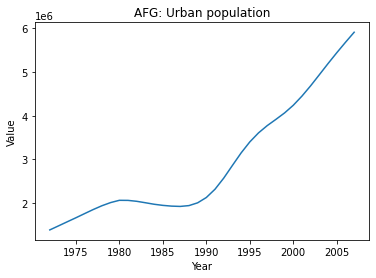

In [21]:
# Here is a sample plot to view Afghanistan's urban population
_ = plt.plot(unstacked_df[unstacked_df['country'] == 'Afghanistan']['year'], 
             unstacked_df[unstacked_df['country'] == 'Afghanistan']['Urban population'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Value')
_ = plt.title('AFG: Urban population')
plt.show()


In [22]:
# Let's see what our dataframe looks like for the first country in our dataset
unstacked_df[unstacked_df['country'] == 'Afghanistan']

series,country,year,Adjusted net national income (annual % growth),Adjusted net national income (constant 2005 US$),Adjusted net national income (current US$),Adjusted net national income per capita (annual % growth),Adjusted net national income per capita (constant 2005 US$),Adjusted net national income per capita (current US$),Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),...,Telephone lines (per 100 people),Terms of trade adjustment (constant LCU),Total natural resources rents (% of GDP),"Total reserves (includes gold, current US$)",Total reserves minus gold (current US$),Trade (% of GDP),Urban population,Urban population (% of total),Urban population growth (annual %),"Use of IMF credit (DOD, current US$)"
0,Afghanistan,1972,NaN,NaN,NaN,NaN,NaN,NaN,0.138399,2.257446e+06,...,NaN,NaN,4.516957,8.128965e+07,2.080285e+07,32.869081,1389151.0,11.9298,6.634620,0.0
1,Afghanistan,1973,NaN,NaN,NaN,NaN,NaN,NaN,0.145555,2.577942e+06,...,NaN,NaN,4.686652,1.262302e+08,2.161318e+07,27.692309,1481339.0,12.3792,6.425364,0.0
2,Afghanistan,1974,NaN,NaN,NaN,NaN,NaN,NaN,0.151152,3.328705e+06,...,NaN,NaN,7.149039,2.014564e+08,2.763836e+07,28.865980,1574530.0,12.8286,6.101041,0.0
3,Afghanistan,1975,NaN,NaN,NaN,NaN,NaN,NaN,0.169077,4.087907e+06,...,0.171290,NaN,7.568906,2.172609e+08,8.654791e+07,26.948358,1666627.0,13.2780,5.684501,0.0
4,Afghanistan,1976,NaN,NaN,NaN,NaN,NaN,NaN,0.156516,4.086801e+06,...,0.173345,NaN,7.103324,2.565056e+08,1.309186e+08,28.086957,1761884.0,13.7574,5.558187,0.0
5,Afghanistan,1977,NaN,NaN,NaN,NaN,NaN,NaN,0.175329,5.291039e+06,...,0.170318,NaN,6.683094,4.310389e+08,2.758209e+08,26.486080,1855690.0,14.2368,5.187290,0.0
6,Afghanistan,1978,NaN,NaN,NaN,NaN,NaN,NaN,0.153522,5.175389e+06,...,0.191673,NaN,6.736402,6.050290e+08,3.905550e+08,24.713804,1942479.0,14.7162,4.570840,0.0
7,Afghanistan,1979,NaN,NaN,NaN,NaN,NaN,NaN,0.155825,5.883546e+06,...,0.190841,NaN,7.901594,9.347790e+08,4.412110e+08,NaN,2014500.0,15.1956,3.640603,0.0
8,Afghanistan,1980,NaN,NaN,NaN,NaN,NaN,NaN,0.137298,5.102752e+06,...,0.195745,NaN,10.621110,9.400359e+08,3.711684e+08,NaN,2066033.0,15.6750,2.525932,0.0
9,Afghanistan,1981,NaN,NaN,NaN,NaN,NaN,NaN,0.179195,6.364148e+06,...,0.244527,NaN,10.522539,6.578809e+08,2.742934e+08,NaN,2064276.0,15.9234,-0.085078,0.0


In [23]:
# We see that some countries, such as Afghanistan are still missing a lot of data. Let's looked at the Series Names
# again, ranked by the number of nulls.
ranked_nulls

series
Adjusted savings: mineral depletion (current US$)                                             0
Adjusted savings: energy depletion (current US$)                                             15
Population (Total)                                                                           91
Population growth (annual %)                                                                 98
Urban population (% of total)                                                               180
                                                                                           ... 
(%) Benefits held by 1st 20% population - Unemp benefits and ALMP                          7696
(%) Generosity of Unemp benefits and ALMP                                                  7696
Net official flows from UN agencies, UNPBF (current US$)                                   7701
Firms with female top manager (% of firms)                                                 7702
Presence of peace keepers (number

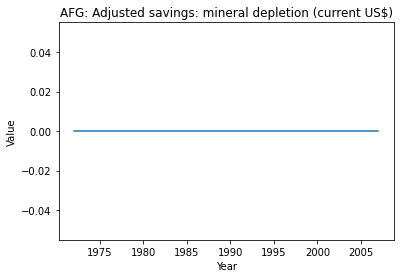

In [24]:
# In the cell above, we see only one column that isn't missing any data. Let's graph that series for Afghanistan. 
# Then, in the following cells, we will plot the second- and third-most populated series for our example country
# of Afghanistan.

# 1 Adjusted savings: mineral depletion (current US$)
_ = plt.plot(unstacked_df[unstacked_df['country'] == 'Afghanistan']['year'], 
             unstacked_df[unstacked_df['country'] == 'Afghanistan']['Adjusted savings: mineral depletion (current US$)'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Value')
_ = plt.title('AFG: Adjusted savings: mineral depletion (current US$)')
plt.show()

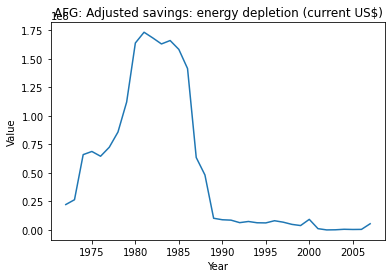

In [25]:
# 2 Adjusted savings: energy depletion (current US$)
_ = plt.plot(unstacked_df[unstacked_df['country'] == 'Afghanistan']['year'], 
             unstacked_df[unstacked_df['country'] == 'Afghanistan']['Adjusted savings: energy depletion (current US$)'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Value')
_ = plt.title('AFG: Adjusted savings: energy depletion (current US$)')
plt.show()

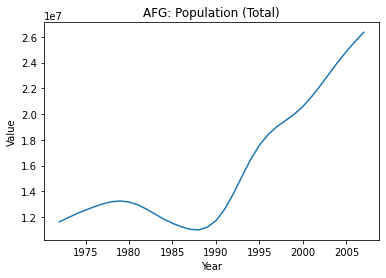

In [26]:
# 3 Population (Total)                                                                         
_ = plt.plot(unstacked_df[unstacked_df['country'] == 'Afghanistan']['year'], 
             unstacked_df[unstacked_df['country'] == 'Afghanistan']['Population (Total)'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Value')
_ = plt.title('AFG: Population (Total)')
plt.show()

In [27]:
unstacked_df

series,country,year,Adjusted net national income (annual % growth),Adjusted net national income (constant 2005 US$),Adjusted net national income (current US$),Adjusted net national income per capita (annual % growth),Adjusted net national income per capita (constant 2005 US$),Adjusted net national income per capita (current US$),Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),...,Telephone lines (per 100 people),Terms of trade adjustment (constant LCU),Total natural resources rents (% of GDP),"Total reserves (includes gold, current US$)",Total reserves minus gold (current US$),Trade (% of GDP),Urban population,Urban population (% of total),Urban population growth (annual %),"Use of IMF credit (DOD, current US$)"
0,Afghanistan,1972,NaN,NaN,NaN,NaN,NaN,NaN,0.138399,2.257446e+06,...,NaN,NaN,4.516957,8.128965e+07,2.080285e+07,32.869081,1389151.0,11.9298,6.634620,0.0
1,Afghanistan,1973,NaN,NaN,NaN,NaN,NaN,NaN,0.145555,2.577942e+06,...,NaN,NaN,4.686652,1.262302e+08,2.161318e+07,27.692309,1481339.0,12.3792,6.425364,0.0
2,Afghanistan,1974,NaN,NaN,NaN,NaN,NaN,NaN,0.151152,3.328705e+06,...,NaN,NaN,7.149039,2.014564e+08,2.763836e+07,28.865980,1574530.0,12.8286,6.101041,0.0
3,Afghanistan,1975,NaN,NaN,NaN,NaN,NaN,NaN,0.169077,4.087907e+06,...,0.171290,NaN,7.568906,2.172609e+08,8.654791e+07,26.948358,1666627.0,13.2780,5.684501,0.0
4,Afghanistan,1976,NaN,NaN,NaN,NaN,NaN,NaN,0.156516,4.086801e+06,...,0.173345,NaN,7.103324,2.565056e+08,1.309186e+08,28.086957,1761884.0,13.7574,5.558187,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7699,Zimbabwe,2003,-18.597169,5.765983e+09,4.835208e+09,-18.803876,454.977986,381.533073,1.441396,7.938799e+07,...,2.374486,-3.442119e+08,5.261810,1.360920e+08,8.518754e+07,70.451989,4438019.0,35.0192,1.462004,316711000.0
7700,Zimbabwe,2004,-11.767952,5.087445e+09,4.730153e+09,-11.906587,400.805636,372.657002,1.396944,7.713997e+07,...,2.497430,-5.638541e+08,7.748060,2.342909e+08,2.232095e+08,76.039609,4498365.0,35.4396,1.350589,309048000.0
7701,Zimbabwe,2005,-7.101213,4.726174e+09,4.726174e+09,-7.229424,371.829698,371.829698,1.595803,8.745984e+07,...,2.580526,-6.867694e+08,7.489343,9.719159e+07,9.719159e+07,76.043707,4558017.0,35.8600,1.317366,125086000.0
7702,Zimbabwe,2006,-8.004865,4.347851e+09,4.305408e+09,-8.104052,341.696427,338.360898,1.707284,8.760166e+07,...,2.637165,-6.339028e+08,11.267126,1.545936e+08,1.545936e+08,82.820650,4620705.0,36.3140,1.365963,128124000.0


In [28]:
# Let's see how many data points are missing for a series that we chose based on what was visible in the cell above.
df_tele_agg = unstacked_df.groupby("country").agg({"Telephone lines (per 100 people)": lambda x: x.isnull().sum()})
(df_tele_agg['Telephone lines (per 100 people)'] > 18).value_counts()

False    197
True      17
Name: Telephone lines (per 100 people), dtype: int64

In [29]:
# Here I decided to just look at the top 10 most populated series. Because I do not anticipate "Surface Area"
# or "Land Area" varying greatly from year-to-year for most countries, I have left these in the list out of curiosity
# and will analyze the other 10 series, which should have more variance. Below are the 12 most populated series.

ranked_nulls[:12]

series
Adjusted savings: mineral depletion (current US$)        0
Adjusted savings: energy depletion (current US$)        15
Population (Total)                                      91
Population growth (annual %)                            98
Urban population (% of total)                          180
Rural population (% of total population)               180
Urban population                                       183
Rural population                                       183
Surface area (sq. km)                                  184
Land area (sq. km)                                     184
Urban population growth (annual %)                     185
Population density (people per sq. km of land area)    275
dtype: int64

In [30]:
# We will now create a list of the top 12 nulls so that we may filter out all but these in a new dataframe. 
top_nulls = list(ranked_nulls[:12].index)

In [31]:
# We will call this new dataframe containing only the top 12 most populated series "top_12_df". However, we see
# that the country and year that we can use for indexing are missing from this new dataframe.
top_12_df = unstacked_df[top_nulls]
top_12_df

series,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,Surface area (sq. km),Land area (sq. km),Urban population growth (annual %),Population density (people per sq. km of land area)
0,0.000000e+00,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,652230.0,652230.0,6.634620,17.853176
1,0.000000e+00,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,652230.0,652230.0,6.425364,18.346829
2,0.000000e+00,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,652230.0,652230.0,6.101041,18.817885
3,0.000000e+00,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,652230.0,652230.0,5.684501,19.244423
4,0.000000e+00,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,652230.0,652230.0,5.558187,19.635420
...,...,...,...,...,...,...,...,...,...,...,...,...
7699,6.419160e+07,9.836209e+06,12673103.0,0.254254,35.0192,64.9808,4438019.0,8235084.0,390760.0,386850.0,1.462004,32.759734
7700,1.254848e+08,6.111326e+07,12693047.0,0.157249,35.4396,64.5604,4498365.0,8194682.0,390760.0,386850.0,1.350589,32.811289
7701,1.277594e+08,4.497854e+07,12710589.0,0.138106,35.8600,64.1400,4558017.0,8152572.0,390760.0,386850.0,1.317366,32.856634
7702,2.281826e+08,4.788289e+07,12724308.0,0.107875,36.3140,63.6860,4620705.0,8103603.0,390760.0,386850.0,1.365963,32.892098


In [32]:
# We pull the country and year columns from the dataframe that we were previously using (unstacked_df) so that we can 
# add them to our new Top 12 dataframe.
ind_cols = unstacked_df.iloc[:, :2]

In [33]:
# Here we concatenate the country and year columns with the top 12 series dataframe to produce our "final_12_df".
final_12_df = pd.concat([ind_cols, top_12_df], axis=1, sort=False)
final_12_df

series,country,year,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,Surface area (sq. km),Land area (sq. km),Urban population growth (annual %),Population density (people per sq. km of land area)
0,Afghanistan,1972,0.000000e+00,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,652230.0,652230.0,6.634620,17.853176
1,Afghanistan,1973,0.000000e+00,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,652230.0,652230.0,6.425364,18.346829
2,Afghanistan,1974,0.000000e+00,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,652230.0,652230.0,6.101041,18.817885
3,Afghanistan,1975,0.000000e+00,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,652230.0,652230.0,5.684501,19.244423
4,Afghanistan,1976,0.000000e+00,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,652230.0,652230.0,5.558187,19.635420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7699,Zimbabwe,2003,6.419160e+07,9.836209e+06,12673103.0,0.254254,35.0192,64.9808,4438019.0,8235084.0,390760.0,386850.0,1.462004,32.759734
7700,Zimbabwe,2004,1.254848e+08,6.111326e+07,12693047.0,0.157249,35.4396,64.5604,4498365.0,8194682.0,390760.0,386850.0,1.350589,32.811289
7701,Zimbabwe,2005,1.277594e+08,4.497854e+07,12710589.0,0.138106,35.8600,64.1400,4558017.0,8152572.0,390760.0,386850.0,1.317366,32.856634
7702,Zimbabwe,2006,2.281826e+08,4.788289e+07,12724308.0,0.107875,36.3140,63.6860,4620705.0,8103603.0,390760.0,386850.0,1.365963,32.892098


In [34]:
# Here we drop the Surface and Land area columns as we expect those to remain fairly constant over time.
final_10_df = final_12_df.drop(['Surface area (sq. km)', 'Land area (sq. km)'], axis=1)

In [35]:
# This shifts our 'Urban Population' numbers by 5 rows and assigns NaNs as the value for the bottom 5 rows.
final_10_df['Urban_Pop_5_Years_Future'] = pd.concat([final_10_df['Urban population'][5:], 
                                                  pd.Series([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN])]).reset_index(drop=True)


In [36]:
# Here we want to see how many NaNs appear in our new column
final_10_df['Urban_Pop_5_Years_Future'].isnull().value_counts()

False    7516
True      188
Name: Urban_Pop_5_Years_Future, dtype: int64

In [37]:
# Here we want to make sure we have 5 fewer NaNs in our original 'Urban population' than our new column
final_10_df['Urban population'].isnull().value_counts()

False    7521
True      183
Name: Urban population, dtype: int64

In [38]:
# Because we are predicting 5 years into the future, any entries in the 'Urban_Pop_5_Years_Future' column for 2003
# or later should technically be NaN (although in our dataframe it will reflect a value for the country below it in 
# the early 1970s), which will not be helpful in training our model. This is why we choose not to include observations
# from the year 2003 or later. We also know that there are other observations where NaN appears in this column. The 
# line of code below ensures that our dataset only contains observations from before 2003 and observations that have
# a value for the urban population five years in the future.

final_10_df.where((final_10_df['year'] < 2003) & (final_10_df['Urban_Pop_5_Years_Future'].notnull()), inplace=True)

In [39]:
# We want the observations for which 'Urban population' is also not null.
final_10_df_clean = final_10_df[final_10_df['Urban population'].notnull()]
final_10_df_clean

series,country,year,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,Urban population growth (annual %),Population density (people per sq. km of land area),Urban_Pop_5_Years_Future
0,Afghanistan,1972.0,0.000000e+00,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,6.634620,17.853176,1855690.0
1,Afghanistan,1973.0,0.000000e+00,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,6.425364,18.346829,1942479.0
2,Afghanistan,1974.0,0.000000e+00,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,6.101041,18.817885,2014500.0
3,Afghanistan,1975.0,0.000000e+00,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,5.684501,19.244423,2066033.0
4,Afghanistan,1976.0,0.000000e+00,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,5.558187,19.635420,2064276.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,Zimbabwe,1998.0,3.574371e+06,2.922644e+06,12229500.0,1.513394,32.9476,67.0524,4029327.0,8200173.0,2.750848,31.613028,4438019.0
7695,Zimbabwe,1999.0,1.121581e+07,0.000000e+00,12384727.0,1.261295,33.3528,66.6472,4130653.0,8254074.0,2.483614,32.014287,4498365.0
7696,Zimbabwe,2000.0,2.259094e+07,1.635434e+06,12503652.0,0.955674,33.7580,66.2420,4220983.0,8282669.0,2.163253,32.321706,4558017.0
7697,Zimbabwe,2001.0,1.491629e+07,2.523939e+07,12586763.0,0.662494,34.1784,65.8216,4301954.0,8284809.0,1.900130,32.536546,4620705.0


In [40]:
# Note that the operations in the 2 cells above caused us to remove Curacao, Kosovo, Sint Maarten (Dutch part), and
# St. Martin (French part) from our dataset because "Urban_Pop_5_Years_Future" was empty for most of the dataset,
# with the exception of 2003-2007, which were dropped from our dataset. We can also see that Kuwait, West Bank and 
# Gaza, and Serbia are missing a few observations since they did not meet the above criteria.
final_10_df_clean['country'].sort_values().value_counts()


Japan                 31
Somalia               31
Ireland               31
Pakistan              31
Guyana                31
                      ..
Bermuda               31
Belize                31
Kuwait                25
West Bank and Gaza    13
Serbia                13
Name: country, Length: 210, dtype: int64

In [41]:
final_10_df_clean['year'] = final_10_df_clean['year'].astype(int)
final_10_df_clean['Urban_Pop_5_Years_Future'] = final_10_df_clean['Urban_Pop_5_Years_Future'].astype(int)

<ipython-input-41-e38a444325a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_10_df_clean['year'] = final_10_df_clean['year'].astype(int)
<ipython-input-41-e38a444325a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_10_df_clean['Urban_Pop_5_Years_Future'] = final_10_df_clean['Urban_Pop_5_Years_Future'].astype(int)


In [42]:
final_10_df_clean

series,country,year,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,Urban population growth (annual %),Population density (people per sq. km of land area),Urban_Pop_5_Years_Future
0,Afghanistan,1972,0.000000e+00,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,6.634620,17.853176,1855690
1,Afghanistan,1973,0.000000e+00,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,6.425364,18.346829,1942479
2,Afghanistan,1974,0.000000e+00,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,6.101041,18.817885,2014500
3,Afghanistan,1975,0.000000e+00,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,5.684501,19.244423,2066033
4,Afghanistan,1976,0.000000e+00,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,5.558187,19.635420,2064276
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,Zimbabwe,1998,3.574371e+06,2.922644e+06,12229500.0,1.513394,32.9476,67.0524,4029327.0,8200173.0,2.750848,31.613028,4438019
7695,Zimbabwe,1999,1.121581e+07,0.000000e+00,12384727.0,1.261295,33.3528,66.6472,4130653.0,8254074.0,2.483614,32.014287,4498365
7696,Zimbabwe,2000,2.259094e+07,1.635434e+06,12503652.0,0.955674,33.7580,66.2420,4220983.0,8282669.0,2.163253,32.321706,4558017
7697,Zimbabwe,2001,1.491629e+07,2.523939e+07,12586763.0,0.662494,34.1784,65.8216,4301954.0,8284809.0,1.900130,32.536546,4620705


In [43]:
# I'm curious to know how many countries are missing the total population to know how many number in our dataset
# were generated through fill instead of recorded data.
missing_total_pop = final_10_df_clean[['country','year','Population (Total)']][final_10_df_clean['Population (Total)'].isnull()]
missing_total_pop

series,country,year,Population (Total)


In [44]:
# We want to ensure that we have 0 NaNs for Urban Population and limited NaNs for our urban population in the future
final_10_df_clean.isnull().sum()

series
country                                                  0
year                                                     0
Adjusted savings: mineral depletion (current US$)        0
Adjusted savings: energy depletion (current US$)         5
Population (Total)                                       0
Population growth (annual %)                             4
Urban population (% of total)                            0
Rural population (% of total population)                 0
Urban population                                         0
Rural population                                         0
Urban population growth (annual %)                       2
Population density (people per sq. km of land area)    179
Urban_Pop_5_Years_Future                                 0
dtype: int64

In [45]:
cols = final_10_df_clean.columns

In [46]:
final_10_df_clean.update(final_10_df_clean.groupby('country')[cols].bfill().fillna(0))

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:5732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [47]:
# Ensure 0 nulls
final_10_df_clean.isnull().sum()

series
country                                                0
year                                                   0
Adjusted savings: mineral depletion (current US$)      0
Adjusted savings: energy depletion (current US$)       0
Population (Total)                                     0
Population growth (annual %)                           0
Urban population (% of total)                          0
Rural population (% of total population)               0
Urban population                                       0
Rural population                                       0
Urban population growth (annual %)                     0
Population density (people per sq. km of land area)    0
Urban_Pop_5_Years_Future                               0
dtype: int64

In [48]:
final_10_df_clean.head()

series,country,year,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,Urban population growth (annual %),Population density (people per sq. km of land area),Urban_Pop_5_Years_Future
0,Afghanistan,1972,0.0,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,6.634620,17.853176,1855690
1,Afghanistan,1973,0.0,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,6.425364,18.346829,1942479
2,Afghanistan,1974,0.0,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,6.101041,18.817885,2014500
3,Afghanistan,1975,0.0,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,5.684501,19.244423,2066033
4,Afghanistan,1976,0.0,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,5.558187,19.635420,2064276


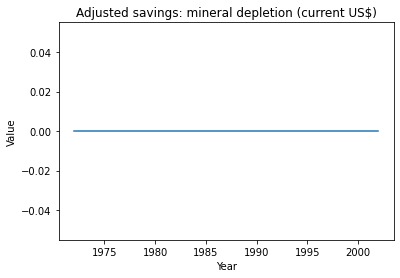

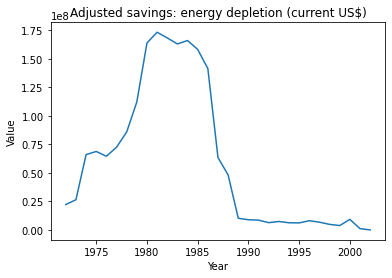

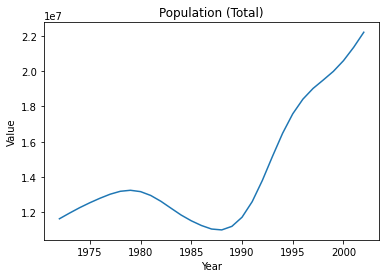

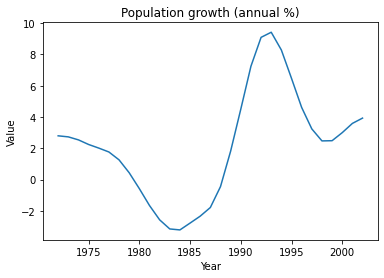

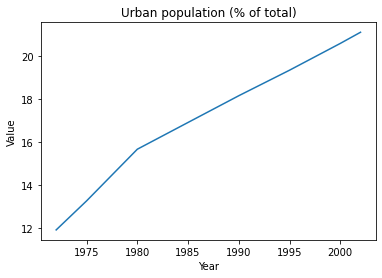

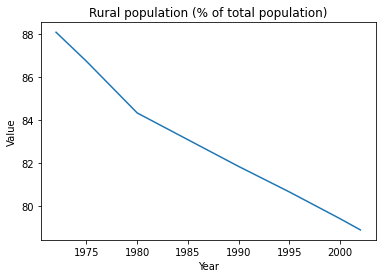

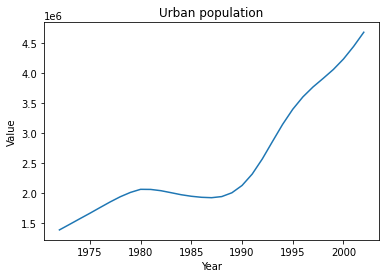

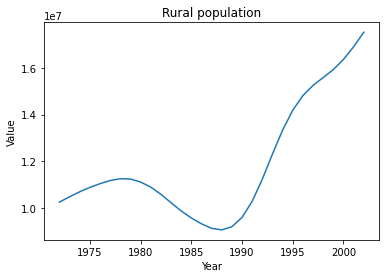

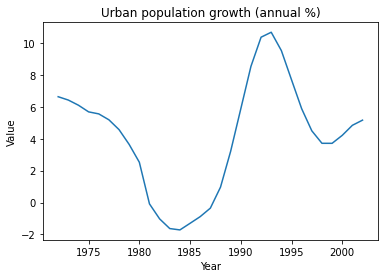

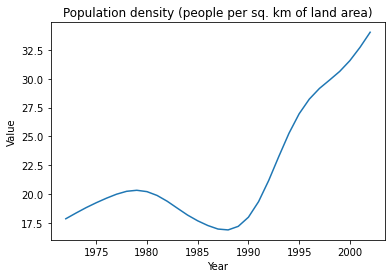

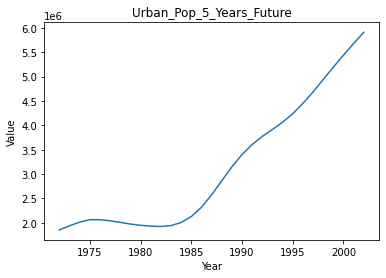

In [49]:
counter = 0

for series_name in cols[2:]:
    _ = plt.plot(final_10_df_clean[final_10_df_clean['country'] == 'Afghanistan']['year'], 
             final_10_df_clean[final_10_df_clean['country'] == 'Afghanistan'][series_name])
    _ = plt.xlabel('Year')
    _ = plt.ylabel('Value')
    _ = plt.title(series_name)
    plt.show()


In [50]:
# chart for Afghanistan
up_afg = final_10_df_clean[final_10_df_clean['country'] == 'Afghanistan'][['year','Urban population']]
up_afg.head()

series,year,Urban population
0,1972,1389151.0
1,1973,1481339.0
2,1974,1574530.0
3,1975,1666627.0
4,1976,1761884.0


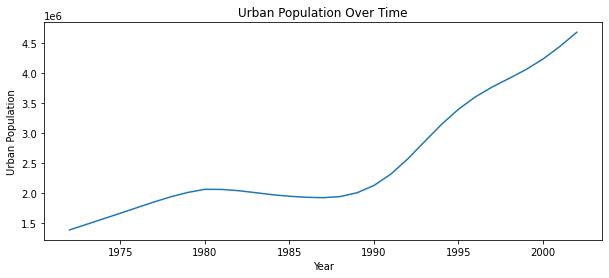

In [51]:
plt.figure(figsize=(10,4))
_ = plt.plot(final_10_df_clean[final_10_df_clean['country'] == 'Afghanistan']['year'], 
             final_10_df_clean[final_10_df_clean['country'] == 'Afghanistan']['Urban population'])
_ = plt.xlabel('Year')
_ = plt.ylabel('Urban Population')
_ = plt.title('Urban Population Over Time')
plt.show()

In [52]:
# Part 2. I am adding region and income data for each of the countries.
df2 = final_10_df_clean.copy()

In [53]:
# We want to be able to group these countries by region and income, 
# so we will read in the data from the Gapminder file
gapminder_data = pd.read_excel('Data Geographies - v1 - by Gapminder.xlsx', sheet_name='list-of-countries-etc')
gapminder_data

,geo,name,four_regions,eight_regions,six_regions,members_oecd_g77,Latitude,Longitude,UN member since,World bank region,"World bank, 4 income groups 2017","World bank, 3 income groups 2017"
0,afg,Afghanistan,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN
1,alb,Albania,europe,europe_east,europe_central_asia,others,41.00000,20.00000,1955-12-14,Europe & Central Asia,Upper middle income,NaN
2,dza,Algeria,africa,africa_north,middle_east_north_africa,g77,28.00000,3.00000,1962-10-08,Middle East & North Africa,Upper middle income,NaN
3,and,Andorra,europe,europe_west,europe_central_asia,others,42.50779,1.52109,1993-07-28,Europe & Central Asia,High income,NaN
4,ago,Angola,africa,africa_sub_saharan,sub_saharan_africa,g77,-12.50000,18.50000,1976-12-01,Sub-Saharan Africa,Lower middle income,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
192,vnm,Vietnam,asia,east_asia_pacific,east_asia_pacific,g77,16.16667,107.83333,1977-09-20,East Asia & Pacific,Lower middle income,NaN
193,yem,Yemen,asia,asia_west,middle_east_north_africa,g77,15.50000,47.50000,1947-09-30,Middle East & North Africa,Lower middle income,NaN
194,zmb,Zambia,africa,africa_sub_saharan,sub_saharan_africa,g77,-14.33333,28.50000,1964-12-01,Sub-Saharan Africa,Lower middle income,NaN
195,zwe,Zimbabwe,africa,africa_sub_saharan,sub_saharan_africa,g77,-19.00000,29.75000,1980-08-25,Sub-Saharan Africa,Low income,NaN


In [54]:
# We merge the two dataframes in order to associate as many countries as possible with a region and income group.
full_df = df2.merge(gapminder_data, how='outer', left_on='country', right_on='name')
full_df

,country,year,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,...,four_regions,eight_regions,six_regions,members_oecd_g77,Latitude,Longitude,UN member since,World bank region,"World bank, 4 income groups 2017","World bank, 3 income groups 2017"
0,Afghanistan,1972.0,0.0,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,...,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN
1,Afghanistan,1973.0,0.0,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,...,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN
2,Afghanistan,1974.0,0.0,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,...,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN
3,Afghanistan,1975.0,0.0,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,...,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN
4,Afghanistan,1976.0,0.0,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,...,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,asia,asia_west,middle_east_north_africa,g77,35.00000,38.00000,1945-10-24,Middle East & North Africa,Lower middle income,NaN
6482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,asia,east_asia_pacific,east_asia_pacific,others,24.00000,121.00000,NaT,East Asia & Pacific,High income,NaN
6483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,americas,america_south,america,g77,8.00000,-66.00000,1945-11-15,Latin America & Caribbean,Upper middle income,NaN
6484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,asia,asia_west,middle_east_north_africa,g77,31.92157,35.20329,NaT,Middle East & North Africa,Lower middle income,NaN


In [55]:
# Since our original dataset has 214 countries and the Gapminder dataset only has 197, we know that some countries
# will not be easily matched to a region and will require some extra work.
countries_wo_region = list(full_df.country[full_df['World bank region'].isnull()].unique())
countries_wo_region

['American Samoa',
 'Aruba',
 'Bahamas, The',
 'Bermuda',
 'Brunei Darussalam',
 'Cabo Verde',
 'Cayman Islands',
 'Channel Islands',
 'Egypt, Arab Rep.',
 'Faeroe Islands',
 'French Polynesia',
 'Gambia, The',
 'Greenland',
 'Guam',
 'Hong Kong SAR, China',
 'Iran, Islamic Rep.',
 'Isle of Man',
 'Korea, Dem. Rep.',
 'Korea, Rep.',
 'Lao PDR',
 'Macao SAR, China',
 'New Caledonia',
 'Northern Mariana Islands',
 'Puerto Rico',
 'Russian Federation',
 'Syrian Arab Republic',
 'Turks and Caicos Islands',
 'Venezuela, RB',
 'Virgin Islands (U.S.)',
 'West Bank and Gaza',
 'Yemen, Rep.',
 nan]

In [56]:
# We know exactly which countries are missing an associated region now, but we do not want to count them all up, 
# so we will find the length of our array.
len(countries_wo_region)

32

In [57]:
# Now we want to see which countries ('names') from the Gapminder dataset were not matche to a country.
names_wo_country = list(full_df.name[full_df['country'].isnull()].unique())
names_wo_country

['Bahamas',
 'Brunei',
 'Cape Verde',
 'Egypt',
 'Gambia',
 'Holy See',
 'Hong Kong, China',
 'Iran',
 'North Korea',
 'South Korea',
 'Lao',
 'Nauru',
 'Russia',
 'Syria',
 'Taiwan',
 'Venezuela',
 'Palestine',
 'Yemen']

In [58]:
# How many names are not matched to a country?
len(names_wo_country)

18

In [59]:
leftover_countries = list(countries_wo_region)
pair_dict = {}

for name in names_wo_country:
    query = name
    choices = leftover_countries
    best_match = process.extractOne(query, choices)
    # From exporing the rough matches with no constraints, we can see that the best match is only accurate at 60 or
    # above, so we add the constraints below
    if best_match[1] > 60:
        pairings = [name, best_match]
        pair_dict[pairings[0]] = pairings[1][0]
        print(pairings)

['Bahamas', ('Bahamas, The', 90)]
['Brunei', ('Brunei Darussalam', 90)]
['Cape Verde', ('Cabo Verde', 80)]
['Egypt', ('Egypt, Arab Rep.', 90)]
['Gambia', ('Gambia, The', 90)]
['Hong Kong, China', ('Hong Kong SAR, China', 95)]
['Iran', ('Iran, Islamic Rep.', 90)]
['North Korea', ('Korea, Rep.', 67)]
['South Korea', ('Korea, Rep.', 67)]
['Lao', ('Lao PDR', 90)]
['Russia', ('Russian Federation', 90)]
['Syria', ('Syrian Arab Republic', 90)]
['Venezuela', ('Venezuela, RB', 95)]
['Yemen', ('Yemen, Rep.', 90)]


In [60]:
pair_dict

{'Bahamas': 'Bahamas, The',
 'Brunei': 'Brunei Darussalam',
 'Cape Verde': 'Cabo Verde',
 'Egypt': 'Egypt, Arab Rep.',
 'Gambia': 'Gambia, The',
 'Hong Kong, China': 'Hong Kong SAR, China',
 'Iran': 'Iran, Islamic Rep.',
 'North Korea': 'Korea, Rep.',
 'South Korea': 'Korea, Rep.',
 'Lao': 'Lao PDR',
 'Russia': 'Russian Federation',
 'Syria': 'Syrian Arab Republic',
 'Venezuela': 'Venezuela, RB',
 'Yemen': 'Yemen, Rep.'}

In [61]:
# We fix North Korea's dictionary entry
pair_dict['North Korea'] = 'Korea, Dem. Rep.'

In [62]:
# Now we ensure that North and South Korea are correctly paired
pair_dict

{'Bahamas': 'Bahamas, The',
 'Brunei': 'Brunei Darussalam',
 'Cape Verde': 'Cabo Verde',
 'Egypt': 'Egypt, Arab Rep.',
 'Gambia': 'Gambia, The',
 'Hong Kong, China': 'Hong Kong SAR, China',
 'Iran': 'Iran, Islamic Rep.',
 'North Korea': 'Korea, Dem. Rep.',
 'South Korea': 'Korea, Rep.',
 'Lao': 'Lao PDR',
 'Russia': 'Russian Federation',
 'Syria': 'Syrian Arab Republic',
 'Venezuela': 'Venezuela, RB',
 'Yemen': 'Yemen, Rep.'}

In [63]:
# We create a copy of our original Gapminder dataframe before we edit it
fixed_df = gapminder_data.copy()

In [64]:
# Using the Gapminder dataframe, we replace the 'name' values with the equivalent 'country' value where applicable.
fixed_df['name'] = fixed_df['name'].apply(lambda x: pair_dict[x] if x in pair_dict else x)

In [65]:
# We ensure that the first example in our list has undergone a name change as expected.
fixed_df[fixed_df['name'] == 'Bahamas, The']

,geo,name,four_regions,eight_regions,six_regions,members_oecd_g77,Latitude,Longitude,UN member since,World bank region,"World bank, 4 income groups 2017","World bank, 3 income groups 2017"
11,bhs,"Bahamas, The",americas,america_north,america,g77,25.04082,-77.37122,1973-08-18,Latin America & Caribbean,High income,NaN


In [66]:
fixed_df

,geo,name,four_regions,eight_regions,six_regions,members_oecd_g77,Latitude,Longitude,UN member since,World bank region,"World bank, 4 income groups 2017","World bank, 3 income groups 2017"
0,afg,Afghanistan,asia,asia_west,south_asia,g77,33.00000,66.00000,1946-11-19,South Asia,Low income,NaN
1,alb,Albania,europe,europe_east,europe_central_asia,others,41.00000,20.00000,1955-12-14,Europe & Central Asia,Upper middle income,NaN
2,dza,Algeria,africa,africa_north,middle_east_north_africa,g77,28.00000,3.00000,1962-10-08,Middle East & North Africa,Upper middle income,NaN
3,and,Andorra,europe,europe_west,europe_central_asia,others,42.50779,1.52109,1993-07-28,Europe & Central Asia,High income,NaN
4,ago,Angola,africa,africa_sub_saharan,sub_saharan_africa,g77,-12.50000,18.50000,1976-12-01,Sub-Saharan Africa,Lower middle income,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
192,vnm,Vietnam,asia,east_asia_pacific,east_asia_pacific,g77,16.16667,107.83333,1977-09-20,East Asia & Pacific,Lower middle income,NaN
193,yem,"Yemen, Rep.",asia,asia_west,middle_east_north_africa,g77,15.50000,47.50000,1947-09-30,Middle East & North Africa,Lower middle income,NaN
194,zmb,Zambia,africa,africa_sub_saharan,sub_saharan_africa,g77,-14.33333,28.50000,1964-12-01,Sub-Saharan Africa,Lower middle income,NaN
195,zwe,Zimbabwe,africa,africa_sub_saharan,sub_saharan_africa,g77,-19.00000,29.75000,1980-08-25,Sub-Saharan Africa,Low income,NaN


In [67]:
fixed_df.drop(['geo', 'four_regions', 'eight_regions', 'six_regions', 'members_oecd_g77',
              'Latitude', 'Longitude', 'UN member since', 'World bank, 3 income groups 2017'], 
              axis=1, inplace=True)

In [68]:
fixed_df

,name,World bank region,"World bank, 4 income groups 2017"
0,Afghanistan,South Asia,Low income
1,Albania,Europe & Central Asia,Upper middle income
2,Algeria,Middle East & North Africa,Upper middle income
3,Andorra,Europe & Central Asia,High income
4,Angola,Sub-Saharan Africa,Lower middle income
...,...,...,...
192,Vietnam,East Asia & Pacific,Lower middle income
193,"Yemen, Rep.",Middle East & North Africa,Lower middle income
194,Zambia,Sub-Saharan Africa,Lower middle income
195,Zimbabwe,Sub-Saharan Africa,Low income


In [69]:
# Instead of taking the time to get more familiar with the "wbdata" library, here I have opted to manually copy values
# from the World Bank website into a separate csv file, ensuring that "country" is exactly the same as in our
# dataframe. This took all of 5 minutes and was, in this case, the optimal choice due to time constraints.
missing_countries = pd.read_csv('missing_countries.csv', header=0)

In [70]:
name_df_full = pd.concat([fixed_df, missing_countries])

In [71]:
name_df_full = name_df_full.sort_values(by='name')#.reset_index(drop=True))
name_df_full

,name,World bank region,"World bank, 4 income groups 2017"
0,Afghanistan,South Asia,Low income
1,Albania,Europe & Central Asia,Upper middle income
2,Algeria,Middle East & North Africa,Upper middle income
0,American Samoa,East Asia & Pacific,Upper middle income
3,Andorra,Europe & Central Asia,High income
...,...,...,...
15,Virgin Islands (U.S.),Latin America & Caribbean,High income
16,West Bank and Gaza,Middle East & North Africa,Lower middle income
193,"Yemen, Rep.",Middle East & North Africa,Lower middle income
194,Zambia,Sub-Saharan Africa,Lower middle income


In [72]:
name_df_full = name_df_full.reset_index(drop=True)

In [73]:
name_df_full

,name,World bank region,"World bank, 4 income groups 2017"
0,Afghanistan,South Asia,Low income
1,Albania,Europe & Central Asia,Upper middle income
2,Algeria,Middle East & North Africa,Upper middle income
3,American Samoa,East Asia & Pacific,Upper middle income
4,Andorra,Europe & Central Asia,High income
...,...,...,...
209,Virgin Islands (U.S.),Latin America & Caribbean,High income
210,West Bank and Gaza,Middle East & North Africa,Lower middle income
211,"Yemen, Rep.",Middle East & North Africa,Lower middle income
212,Zambia,Sub-Saharan Africa,Lower middle income


In [74]:
# We merged the 2 dataframes the first time but saw that some values did not match up as expected. We will now go back
# and merge our fixed Gapminder dataset with our main dataset that we loaded at the start of this notebook. 
final_df = df2.merge(name_df_full, how='left', left_on='country', right_on='name')
final_df

,country,year,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,Urban population growth (annual %),Population density (people per sq. km of land area),Urban_Pop_5_Years_Future,name,World bank region,"World bank, 4 income groups 2017"
0,Afghanistan,1972,0.000000e+00,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,6.634620,17.853176,1855690,Afghanistan,South Asia,Low income
1,Afghanistan,1973,0.000000e+00,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,6.425364,18.346829,1942479,Afghanistan,South Asia,Low income
2,Afghanistan,1974,0.000000e+00,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,6.101041,18.817885,2014500,Afghanistan,South Asia,Low income
3,Afghanistan,1975,0.000000e+00,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,5.684501,19.244423,2066033,Afghanistan,South Asia,Low income
4,Afghanistan,1976,0.000000e+00,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,5.558187,19.635420,2064276,Afghanistan,South Asia,Low income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,Zimbabwe,1998,3.574371e+06,2.922644e+06,12229500.0,1.513394,32.9476,67.0524,4029327.0,8200173.0,2.750848,31.613028,4438019,Zimbabwe,Sub-Saharan Africa,Low income
6464,Zimbabwe,1999,1.121581e+07,0.000000e+00,12384727.0,1.261295,33.3528,66.6472,4130653.0,8254074.0,2.483614,32.014287,4498365,Zimbabwe,Sub-Saharan Africa,Low income
6465,Zimbabwe,2000,2.259094e+07,1.635434e+06,12503652.0,0.955674,33.7580,66.2420,4220983.0,8282669.0,2.163253,32.321706,4558017,Zimbabwe,Sub-Saharan Africa,Low income
6466,Zimbabwe,2001,1.491629e+07,2.523939e+07,12586763.0,0.662494,34.1784,65.8216,4301954.0,8284809.0,1.900130,32.536546,4620705,Zimbabwe,Sub-Saharan Africa,Low income


In [75]:
# Let's make sure that everything is matched up nicely, and there is no missing data.
final_df.isnull().sum()

country                                                0
year                                                   0
Adjusted savings: mineral depletion (current US$)      0
Adjusted savings: energy depletion (current US$)       0
Population (Total)                                     0
Population growth (annual %)                           0
Urban population (% of total)                          0
Rural population (% of total population)               0
Urban population                                       0
Rural population                                       0
Urban population growth (annual %)                     0
Population density (people per sq. km of land area)    0
Urban_Pop_5_Years_Future                               0
name                                                   0
World bank region                                      0
World bank, 4 income groups 2017                       0
dtype: int64

In [76]:
final_df.drop('name', axis=1, inplace=True)

In [77]:
final_df

,country,year,Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Urban population (% of total),Rural population (% of total population),Urban population,Rural population,Urban population growth (annual %),Population density (people per sq. km of land area),Urban_Pop_5_Years_Future,World bank region,"World bank, 4 income groups 2017"
0,Afghanistan,1972,0.000000e+00,2.233065e+07,11644377.0,2.794796,11.9298,88.0702,1389151.0,10255226.0,6.634620,17.853176,1855690,South Asia,Low income
1,Afghanistan,1973,0.000000e+00,2.654146e+07,11966352.0,2.727531,12.3792,87.6208,1481339.0,10485013.0,6.425364,18.346829,1942479,South Asia,Low income
2,Afghanistan,1974,0.000000e+00,6.606462e+07,12273589.0,2.535101,12.8286,87.1714,1574530.0,10699059.0,6.101041,18.817885,2014500,South Asia,Low income
3,Afghanistan,1975,0.000000e+00,6.882184e+07,12551790.0,2.241357,13.2780,86.7220,1666627.0,10885163.0,5.684501,19.244423,2066033,South Asia,Low income
4,Afghanistan,1976,0.000000e+00,6.463635e+07,12806810.0,2.011378,13.7574,86.2426,1761884.0,11044926.0,5.558187,19.635420,2064276,South Asia,Low income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,Zimbabwe,1998,3.574371e+06,2.922644e+06,12229500.0,1.513394,32.9476,67.0524,4029327.0,8200173.0,2.750848,31.613028,4438019,Sub-Saharan Africa,Low income
6464,Zimbabwe,1999,1.121581e+07,0.000000e+00,12384727.0,1.261295,33.3528,66.6472,4130653.0,8254074.0,2.483614,32.014287,4498365,Sub-Saharan Africa,Low income
6465,Zimbabwe,2000,2.259094e+07,1.635434e+06,12503652.0,0.955674,33.7580,66.2420,4220983.0,8282669.0,2.163253,32.321706,4558017,Sub-Saharan Africa,Low income
6466,Zimbabwe,2001,1.491629e+07,2.523939e+07,12586763.0,0.662494,34.1784,65.8216,4301954.0,8284809.0,1.900130,32.536546,4620705,Sub-Saharan Africa,Low income


In [78]:
cols = ['country', 'year', 'World bank region', 'World bank, 4 income groups 2017', 
        'Adjusted savings: mineral depletion (current US$)', 'Adjusted savings: energy depletion (current US$)', 
        'Population (Total)', 'Population growth (annual %)', 'Population density (people per sq. km of land area)',
        'Rural population (% of total population)', 'Urban population (% of total)', 'Rural population', 
        'Urban population', 'Urban population growth (annual %)', 'Urban_Pop_5_Years_Future']

In [79]:
final_df = final_df.reindex(columns=cols)

In [80]:
final_df 

,country,year,World bank region,"World bank, 4 income groups 2017",Adjusted savings: mineral depletion (current US$),Adjusted savings: energy depletion (current US$),Population (Total),Population growth (annual %),Population density (people per sq. km of land area),Rural population (% of total population),Urban population (% of total),Rural population,Urban population,Urban population growth (annual %),Urban_Pop_5_Years_Future
0,Afghanistan,1972,South Asia,Low income,0.000000e+00,2.233065e+07,11644377.0,2.794796,17.853176,88.0702,11.9298,10255226.0,1389151.0,6.634620,1855690
1,Afghanistan,1973,South Asia,Low income,0.000000e+00,2.654146e+07,11966352.0,2.727531,18.346829,87.6208,12.3792,10485013.0,1481339.0,6.425364,1942479
2,Afghanistan,1974,South Asia,Low income,0.000000e+00,6.606462e+07,12273589.0,2.535101,18.817885,87.1714,12.8286,10699059.0,1574530.0,6.101041,2014500
3,Afghanistan,1975,South Asia,Low income,0.000000e+00,6.882184e+07,12551790.0,2.241357,19.244423,86.7220,13.2780,10885163.0,1666627.0,5.684501,2066033
4,Afghanistan,1976,South Asia,Low income,0.000000e+00,6.463635e+07,12806810.0,2.011378,19.635420,86.2426,13.7574,11044926.0,1761884.0,5.558187,2064276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,Zimbabwe,1998,Sub-Saharan Africa,Low income,3.574371e+06,2.922644e+06,12229500.0,1.513394,31.613028,67.0524,32.9476,8200173.0,4029327.0,2.750848,4438019
6464,Zimbabwe,1999,Sub-Saharan Africa,Low income,1.121581e+07,0.000000e+00,12384727.0,1.261295,32.014287,66.6472,33.3528,8254074.0,4130653.0,2.483614,4498365
6465,Zimbabwe,2000,Sub-Saharan Africa,Low income,2.259094e+07,1.635434e+06,12503652.0,0.955674,32.321706,66.2420,33.7580,8282669.0,4220983.0,2.163253,4558017
6466,Zimbabwe,2001,Sub-Saharan Africa,Low income,1.491629e+07,2.523939e+07,12586763.0,0.662494,32.536546,65.8216,34.1784,8284809.0,4301954.0,1.900130,4620705


In [81]:
# Save the clean dataframe to a csv for the next part of the project
final_df.to_csv('Cleaned_Training_Set.csv')